# Проект для «Vshop»

Построение модели и выбор наиболее качественной для определения токсичности коментариев 
Получен исходныый набор данных с разметкой о токсичности правок.

In [1]:
# ! pip install pymystem3
# ! pip install transformers
# ! pip install optuna

### Среда и инструменты
Импорт библиотек

In [10]:
import pandas as pd
import numpy as np
import torch
import re
import time
import warnings
import nltk
# import optuna
import catboost
import lightgbm
import sklearn
import transformers
import matplotlib.pyplot as plt

from transformers import pipeline
from tqdm import notebook
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, make_scorer, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# from optuna.integration import OptunaSearchCV
from sklearn.datasets import make_classification
# настройка полного отображения колонок
pd.options.display.max_columns = None

# сразу запишем
warnings.simplefilter("ignore")
stopwords = set(stopwords.words('english'))
m = Mystem()
STATE = 12345
scores = []

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [11]:
def open_file(name):
    try:
        return pd.read_csv(name, index_col=[0], parse_dates=[0])
    except FileNotFoundError:
        return pd.read_csv('/datasets/' + name, index_col=[0], parse_dates=[0])


# чтение файла
# df_start = open_file('toxic_comments.csv')

In [12]:
# функция анализа DF
def analysis(df):
    sep = '\n' + 120*'-' + '\n'
    print(sep)
    print('Первые пять строк DF:', sep)
    display(df.head(5))
    print('Описание:', sep)
    display(df.describe().round(2))
    print('Количество строк и столбцов:', sep)
    display(df.shape)
    print('Общая информация:', sep)
    display(df.info())
    print('Количество пропущеных значений в столбцах:', sep)
    display(df.isna().sum())
    print('Названия столбцов:', sep)
    name_st = df.columns.tolist()
    display(name_st)
    print('Количество уникальных значений в столбцах:', sep)
    for i in (name_st):
        print(i, ':', df[i].value_counts().count())
    print(sep)

### Обзор и коррекция исходных данных

In [13]:
# анализ DF
analysis(df_start)


------------------------------------------------------------------------------------------------------------------------

Первые пять строк DF: 
------------------------------------------------------------------------------------------------------------------------



,toxic
text,
"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
"You, sir, are my hero. Any chance you remember what page that's on?",0


Описание: 
------------------------------------------------------------------------------------------------------------------------



,toxic
count,159571.0
mean,0.1
std,0.3
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Количество строк и столбцов: 
------------------------------------------------------------------------------------------------------------------------



(159571, 1)

Общая информация: 
------------------------------------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 to "
And ... I really don't think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them.   "
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   toxic   159571 non-null  int64
dtypes: int64(1)
memory usage: 2.4+ MB


None

Количество пропущеных значений в столбцах: 
------------------------------------------------------------------------------------------------------------------------



toxic    0
dtype: int64

Названия столбцов: 
------------------------------------------------------------------------------------------------------------------------



['toxic']

Количество уникальных значений в столбцах: 
------------------------------------------------------------------------------------------------------------------------

toxic : 2

------------------------------------------------------------------------------------------------------------------------



In [14]:
# копируем исходные данные в "df" для дальнейшей работы
# сбрасываем индексы
df = df_start.copy()
df = df.reset_index() 
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [15]:
# wordnet lemmatization 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

# функция лематизации текста
def lem(df): 
    some_text = df.lower()
    some_text =  " ".join(re.sub(r'[^a-zA-Z ]', ' ', some_text).split())
    word_list = nltk.word_tokenize(some_text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    return lemmatized_output 

In [16]:
%%time

df['text'] = df['text'].apply(lem)

# df = open_file('lemma_df.csv')

CPU times: user 17min 9s, sys: 1min 38s, total: 18min 48s
Wall time: 18min 49s


In [25]:
# оценим 
df
df.duplicated().sum()
df.drop_duplicates(inplace=True, ignore_index=True)

In [26]:
df

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
...,...,...
158254,and for the second time of ask when your view ...,0
158255,you should be ashamed of yourself that be a ho...,0
158256,spitzer umm there no actual article for prosti...,0
158257,and it look like it be actually you who put on...,0


In [ ]:
# оценим пропуски
display(df.loc[df['text'].isna()])

# заменим одинокий пропуск
df['text'] = df['text'].fillna('unknown')

In [27]:
%%time
# делим на таргет и фичи
features = df.drop(['toxic'], axis=1)
target = df['toxic']

CPU times: user 7.63 ms, sys: 352 µs, total: 7.99 ms
Wall time: 7.56 ms


In [28]:
# отделяем 60% данных для обучающей выборки
features_train, features_temp, target_train, target_temp = train_test_split(features,
                                                                            target,
                                                                            test_size=0.40,
                                                                            random_state=STATE,
                                                                            stratify=target)
# отделяем по 20% данных для валидационной/тестовой выборок
features_valid, features_test, target_valid, target_test = train_test_split(features_temp,
                                                                            target_temp,
                                                                            test_size=0.50,
                                                                            random_state=STATE)

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(
    features_train['text'].values)
features_test = count_tf_idf.transform(
    features_test['text'].values)
features_valid = count_tf_idf.transform(
    features_valid['text'].values)

display(features_train.shape, target_train.shape, features_valid.shape,
        target_valid.shape, features_test.shape, target_test.shape)

(94955, 111564)

(94955,)

(31652, 111564)

(31652,)

(31652, 111564)

(31652,)

###  Вывод:
Проведена лемматизация текста, очищен от лишних символов. Итоговый результат был сохранен отдельным файлом .CSV для сокращения времени тестирования моделей. Выборка разделена на обучающую и тестовую 4:1. Выделены признаки и целевой признак. 

## Обучение

In [13]:
# Функция объединения результатов обучения разных моделей
def union_results(scores):
    '''
    Функция для объединения результатов обучения разных моделей
    scores - список словарей results с результатами обучения на выходе функций с моделями
    '''
    # словарь с готовыми ключами и пустыми списками в нем
    results = {i: [] for i in scores[0].keys()}

    # собираем все результаты в словарь 'results'
    for result in scores:
        for key, value in result.items():
            results[key].append(value)

        # собираем результаты в таблицу
    results = pd.DataFrame(results)
    return results

In [14]:
# Функция для получения модели с наилучшими гиперпараметрами с помощью optuna
# простые модели -- DecisionTree/RandomForest/CatBoost/LGBM
# вход: модель и тренировочные признаки
# выход: модель с подобраными гиперпараметрами

def tuning_optuna_cv(model, X, y, params=None, cv=5, timeseries_cv=0,
                     n_trials=10, scoring=None, random_state=None, get_time=False, verbose=None, task_type=None):
    """
    model - модель на вход
    X - признаки
    y - целевой признак
    params - словарь параметров (должен быть заточен под оптюновский интерфейс)
    cv_num - количество подвыборок для кросс-валидации
    timeseries_cv - для временных рядов, количество подвыборок для кросс-валидации
    n_trials - количество проводимых экспериментов для поиска гиперпараметров
    scoring - метрика, на основе которой будут подбираться гиперпараметры модели; если не указана, используется встроенная
                                        в модель метрика
    get_time - получение затраченного времени на подбор гиперпараметров в минутах

    """
    opt_distr_int = optuna.distributions.IntUniformDistribution
    opt_distr_float = optuna.distributions.LogUniformDistribution

    if timeseries_cv >= 2:
        cv = TimeSeriesSplit(n_splits=timeseries_cv)

    if get_time == True:
        start_time = time.time()

    if (type(model).__name__ == 'DecisionTreeRegressor' or
            type(model).__name__ == 'DecisionTreeClassifier'):

        param_distributions = {
            'min_samples_leaf': opt_distr_int(2, 50),
            'min_samples_split': opt_distr_int(2, 50),
            'max_depth': opt_distr_int(1, 50)
        }

        if params != None:
            param_distributions = params

        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(X, y)

        best_model = optuna_search.best_estimator_

        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {optuna_search.best_score_}\n')

        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')

        return best_model

    if (type(model).__name__ == 'RandomForestRegressor' or
            type(model).__name__ == 'RandomForestClassifier'):

        param_distributions = {
            'n_estimators': opt_distr_int(50, 200),
            'min_samples_split': opt_distr_int(2, 25),
            'max_depth': opt_distr_int(1, 50),
            'min_samples_leaf': opt_distr_int(2, 25)
        }

        if params != None:
            param_distributions = params

        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(X, y)

        best_model = optuna_search.best_estimator_

        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {optuna_search.best_score_}\n')

        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')

        return best_model

    if (type(model).__name__ == 'CatBoostRegressor' or
            type(model).__name__ == 'CatBoostClassifier'):

        param_distributions = {
            'iterations': opt_distr_int(50, 100),
            'learning_rate': opt_distr_float(0.02, 0.04),
            'depth': opt_distr_int(2, 10, 2)
        }

        if params != None:
            param_distributions = params

        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state, verbose=verbose
        )
        optuna_search.fit(X, y)

        best_model = optuna_search.best_estimator_

        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {optuna_search.best_score_}\n')

        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')

        return best_model

    if (type(model).__name__ == 'LGBMRegressor' or
            type(model).__name__ == 'LGBMClassifier'):

        param_distributions = {
            'n_estimators': opt_distr_int(10, 300),
            'learning_rate': opt_distr_float(0.01, 1.0),
            'max_depth': opt_distr_int(1, 16)
        }

        if params != None:
            param_distributions = params

        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(X, y)

        best_model = optuna_search.best_estimator_

        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {optuna_search.best_score_}\n')

        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')

        return best_model

    else:
        print('Модель не поддерживается! Попробуйте другую')

In [15]:
%%time
# прогон по GS_CV LogisticRegression
model = LogisticRegression(random_state=STATE, class_weight='balanced')
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.5, 1.0, 5.0, 15.0],
    'intercept_scaling': range(5, 100, 40),
    'solver': ['liblinear']
}
lr_gs = GridSearchCV(model, params, cv=3, scoring='f1',
                     verbose=True).fit(features_train, target_train)
target_predictions = lr_gs.predict(features_valid)
f1_val = f1_score(target_valid, target_predictions)
print('f1_valid:', f1_val)
print()
print('лучшие параметры:', lr_gs.best_params_)
result = {'model': 'LogisticRegression_GS_CV', 'f1_valid': f1_val}

# добавление словаря в список "scores"
scores.append(result)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1_valid: 0.7528604118993135

лучшие параметры: {'C': 5.0, 'intercept_scaling': 45, 'penalty': 'l1', 'solver': 'liblinear'}
CPU times: user 6min 7s, sys: 34.2 s, total: 6min 41s
Wall time: 3min 56s


In [16]:
%%time
# прогон по LogisticRegression c лучшими параметрами

model = LogisticRegression(random_state=STATE, class_weight='balanced', C=5.0,
                           intercept_scaling=5, penalty='l2', solver='liblinear')
model.fit(features_train, target_train)
prediction_lr = model.predict(features_valid)
f1_lr = f1_score(target_valid, prediction_lr)
print('f1:', f1_lr)

result_lr = {'model': 'LogisticRegression_best', 'f1_valid': f1_lr}

# добавление словаря в список "scores"
scores.append(result_lr)

f1: 0.7542456140350877
CPU times: user 5.14 s, sys: 1.45 s, total: 6.59 s
Wall time: 956 ms


In [17]:
%%time
# прогон по DecisionTreeClassifier с optuna

model_dtc = tuning_optuna_cv(DecisionTreeClassifier(), features_train, target_train, params=None,
                             cv=3, timeseries_cv=0, n_trials=5, scoring='f1', random_state=STATE, get_time=True)

prediction_dtc = model_dtc.predict(features_valid)
f1_dtc = f1_score(target_valid, prediction_dtc)

# print('f1:', f1_dtc)

result_dtc = {'model': 'DecisionTreeClassifier_OPT', 'f1_valid': f1_dtc}

# добавление словаря в список "scores"
scores.append(result_dtc)


[I 2022-06-19 01:38:52,605] A new study created in memory with name: no-name-0d71eb30-cca8-414e-ac57-f43455941a24
[I 2022-06-19 01:39:34,598] Trial 0 finished with value: 0.6925531832423767 and parameters: {'min_samples_leaf': 39, 'min_samples_split': 31, 'max_depth': 46}. Best is trial 0 with value: 0.6925531832423767.
[I 2022-06-19 01:39:45,313] Trial 1 finished with value: 0.5583262451509956 and parameters: {'min_samples_leaf': 7, 'min_samples_split': 50, 'max_depth': 6}. Best is trial 0 with value: 0.6925531832423767.
[I 2022-06-19 01:39:59,434] Trial 2 finished with value: 0.6450399623335127 and parameters: {'min_samples_leaf': 37, 'min_samples_split': 15, 'max_depth': 15}. Best is trial 0 with value: 0.6925531832423767.
[I 2022-06-19 01:40:24,362] Trial 3 finished with value: 0.7025275827106737 and parameters: {'min_samples_leaf': 23, 'min_samples_split': 26, 'max_depth': 44}. Best is trial 3 with value: 0.7025275827106737.
[I 2022-06-19 01:40:40,124] Trial 4 finished with value:

Подобранные параметры модели: {'min_samples_leaf': 23, 'min_samples_split': 26, 'max_depth': 44}

Полученная метрика: 0.7025275827106737

Затраченное время на подбор: 1.94 мин
CPU times: user 1min 40s, sys: 490 ms, total: 1min 41s
Wall time: 1min 56s


In [18]:
%%time
# прогон по GS_CV DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=STATE)
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 15, 5))
}
tree_gs_dtc = GridSearchCV(tree, params, cv=5, scoring='f1', verbose=True).fit(
    features_train, target_train)
prediction_tree = tree_gs_dtc.predict(features_valid)
f1_val = f1_score(target_valid, prediction_tree)
print('лучший результат f1:', tree_gs_dtc.best_score_)
print()
print('лучшие параметры:', tree_gs_dtc.best_params_)

print('f1_valid:', f1_val)

result_gs_dtc = {'model': 'DecisionTreeClassifier_GS',
                 'f1_valid': f1_val}

# добавление словаря в список "scores"
scores.append(result_gs_dtc)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
лучший результат f1: 0.6138010715245692

лучшие параметры: {'criterion': 'gini', 'max_depth': 11}
f1_valid: 0.6114701130856219
CPU times: user 2min 28s, sys: 230 ms, total: 2min 29s
Wall time: 2min 29s


In [19]:
%%time
# прогон по GS_CV RandomForestClassifier
model = RandomForestClassifier(random_state=STATE)
params = {
    'n_estimators': range(10, 120, 40),
    'max_depth': range(10, 120, 40),
    'max_leaf_nodes': range(10, 60, 20)
}
tree_gs_rfc = GridSearchCV(model, params, cv=3, scoring='f1', verbose=True).fit(
    features_train, target_train)
target_predictions = tree_gs_rfc.predict(features_valid)
f1_val = f1_score(target_valid, target_predictions)
print('f1_valid:', f1_val)
print()
print('лучшие параметры:', tree_gs_rfc.best_params_)

result_gs_rfc = {'model': 'RandomForestClassifier_GS',
                 'f1_valid': f1_val}

# добавление словаря в список "scores"
scores.append(result_gs_rfc)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
f1_valid: 0.03092783505154639

лучшие параметры: {'max_depth': 50, 'max_leaf_nodes': 50, 'n_estimators': 10}
CPU times: user 11min 6s, sys: 1.7 s, total: 11min 8s
Wall time: 11min 8s


In [20]:
%%time
# прогон по RandomForestClassifier с optuna
model_rfc = tuning_optuna_cv(RandomForestClassifier(), features_train, target_train, params=None,
                             cv=3, timeseries_cv=0, n_trials=5, scoring='f1', random_state=STATE, get_time=True)

prediction_rfc = model_rfc.predict(features_valid)
f1_rfc = f1_score(target_valid, prediction_rfc)

# print('f1:', f1_rfc)

result_rfc = {'model': 'RandomForestClassifier_OPT', 'f1_valid': f1_rfc}

# добавление словаря в список "scores"
scores.append(result_rfc)


[I 2022-06-19 01:54:26,861] A new study created in memory with name: no-name-add7a168-2340-4bd2-812f-84232c108e26
[I 2022-06-19 01:57:28,773] Trial 0 finished with value: 0.028160389103455762 and parameters: {'n_estimators': 165, 'min_samples_split': 16, 'max_depth': 46, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.028160389103455762.
[I 2022-06-19 02:00:22,876] Trial 1 finished with value: 0.011317103366899096 and parameters: {'n_estimators': 200, 'min_samples_split': 4, 'max_depth': 37, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.028160389103455762.
[I 2022-06-19 02:01:18,188] Trial 2 finished with value: 0.00020697505950532965 and parameters: {'n_estimators': 93, 'min_samples_split': 12, 'max_depth': 26, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.028160389103455762.
[I 2022-06-19 02:02:13,168] Trial 3 finished with value: 0.00020697505950532965 and parameters: {'n_estimators': 120, 'min_samples_split': 20, 'max_depth': 19, 'min_samples_leaf': 20}. Best

Подобранные параметры модели: {'n_estimators': 165, 'min_samples_split': 16, 'max_depth': 46, 'min_samples_leaf': 4}

Полученная метрика: 0.028160389103455762

Затраченное время на подбор: 10.02 мин
CPU times: user 10min 1s, sys: 1.07 s, total: 10min 2s
Wall time: 10min 2s


In [21]:
%%time
# прогон по LGBMClassifier с optuna

model_lgbm = tuning_optuna_cv(LGBMClassifier(), features_train, target_train, params=None,
                              cv=5, timeseries_cv=0, n_trials=10, scoring='f1', random_state=STATE, get_time=True)

prediction_lgbm = model_lgbm.predict(features_valid)
f1_lgbm = f1_score(target_valid, prediction_lgbm)

result_lgbm = {'model': 'LGBMClassifier_OPT', 'f1_valid': f1_lgbm}

# добавление словаря в список "scores"
scores.append(result_lgbm)


[I 2022-06-19 02:04:29,152] A new study created in memory with name: no-name-c5786aab-7b24-4d21-9ee2-db7209261d8c
[I 2022-06-19 02:05:22,205] Trial 0 finished with value: 0.7558349882575222 and parameters: {'n_estimators': 232, 'learning_rate': 0.16522559799629474, 'max_depth': 15}. Best is trial 0 with value: 0.7558349882575222.
[I 2022-06-19 02:05:32,414] Trial 1 finished with value: 0.6551098657510904 and parameters: {'n_estimators': 44, 'learning_rate': 0.97320861463424, 'max_depth': 2}. Best is trial 0 with value: 0.7558349882575222.
[I 2022-06-19 02:06:04,950] Trial 2 finished with value: 0.6196612279431908 and parameters: {'n_estimators': 223, 'learning_rate': 0.03667544624096302, 'max_depth': 5}. Best is trial 0 with value: 0.7558349882575222.
[I 2022-06-19 02:06:42,753] Trial 3 finished with value: 0.7263680332172895 and parameters: {'n_estimators': 136, 'learning_rate': 0.10216395038172299, 'max_depth': 14}. Best is trial 0 with value: 0.7558349882575222.
[I 2022-06-19 02:07:

Подобранные параметры модели: {'n_estimators': 232, 'learning_rate': 0.16522559799629474, 'max_depth': 15}

Полученная метрика: 0.7558349882575222

Затраченное время на подбор: 5.92 мин
CPU times: user 39min 2s, sys: 3min 37s, total: 42min 39s
Wall time: 5min 55s


In [27]:
# оценим табличку валидационных результатов по F1
union_results(scores)

,model,f1_valid
0,LogisticRegression_GS_CV,0.752860
1,LogisticRegression_best,0.754246
2,DecisionTreeClassifier_OPT,0.695903
3,DecisionTreeClassifier_GS,0.611470
4,RandomForestClassifier_GS,0.030928
5,RandomForestClassifier_OPT,0.024338
6,LGBMClassifier_OPT,0.762547


In [31]:
%%time
# пройдемся лучшей вариацией LGBMClassifier по тестовой выборке 
prediction_lgbm_test = model_lgbm.predict(features_test)
f1_lgbm_test = f1_score(target_test, prediction_lgbm_test)
print('f1_test_LGBM:', f1_lgbm_test)

f1_test_LGBM: 0.7624466571834992
CPU times: user 3.26 s, sys: 31.4 ms, total: 3.29 s
Wall time: 434 ms


In [32]:
%%time
# пройдемся лучшей вариацией LR по тестовой выборке 

target_predictions_test = lr_gs.predict(features_test)
f1_lr_test = f1_score(target_test, target_predictions_test)
print('f1_test_LR:', f1_lr_test)

f1_test_LR: 0.7541786743515851
CPU times: user 11.3 ms, sys: 890 µs, total: 12.2 ms
Wall time: 11.1 ms


###  Вывод:
F1 более 75 % получено в моделях Логистической регрессии с небольшим перебором параметров и в модели LGBMClassifier с подбором параметров с помощью OPTUNA. Результаты достаточно предсказуемы. Удивило, что случайный лес показал столь низкий результат(f1: 0.02740) в работе с текстами по сравнению с остальными моделями. По скорости работы в соотношении с качеством предсказаний, пожалуй, стоит остановиться на модели LogisticRegression. 12.2 ms в сравнении с 3.29 s от LGBMClassifier.

## Матрица ошибок

<Figure size 1152x576 with 0 Axes>

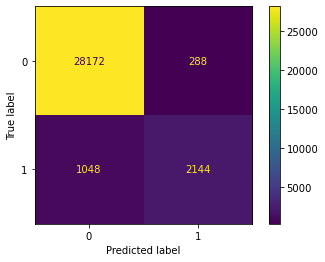

In [35]:
# Матрица ошибок LGBMClassifier
confusion_matrix(target_test, prediction_lgbm_test)

plt.figure(figsize=(16, 8))

(ConfusionMatrixDisplay(confusion_matrix(target_test, prediction_lgbm_test))).plot()
plt.show()


<Figure size 1152x576 with 0 Axes>

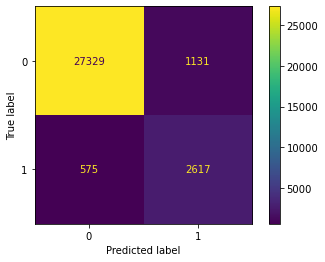

In [34]:
# Матрица ошибок LR
confusion_matrix(target_test, target_predictions_test)

plt.figure(figsize=(16, 8))
(ConfusionMatrixDisplay(confusion_matrix(target_test, target_predictions_test))).plot()
plt.show()

###  Вывод:
LGBMClassifier предсказыавет неверные значения с вероятностью 4.4%  - вполне допустимая погрешность. 
LogisticRegression предсказыавет неверные значения с вероятностью 5.8% - разница в полтора процента с LGBMClassifier, при этом скорость обучения выше в несколько десятков раз. 

## Общий вывод:
Проанализированы, почищены и закодированы исходные данные. Проедено разделение на тестовую, валидационную и обучающую выборки. Обучено 5 моделей классификации, подобраны оптимальные гиперпараметры по гармоническому среднему между точностью и полнотой('F1'). Выделены оптимальные модели по качеству данной метрики('LGBMClassifier/LogisticRegression'). Приведён анализ по скорости работы моделей и по матрицам неточностей. По суммарным параметрам выбрана модель LogisticRegression для постоянного использования. 